# Implement ARIMA Prediction Model
- Examine stationarity and autocorrelation
- Attempt ARIMA model (*SUSPENDED*)

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# local import
from rdforecast import datasets

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# retrieve data from source url (if filepath is None)
data = datasets.load_training_data(filepath='./input/training.csv')
data = datasets.check_sanity(data)
data = datasets.process_timestamp(data)

Data loaded.
TAZ: 1329
N: 4206321
  geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
No missing values found.
First day in sequence: 1
Last day in sequence: 61


# 1. Statistical Examination

## 1.1 Stationary test
- H0: time series is non-stationary 

In [4]:
# specific TAZ
# taz_demand = data['geohash6'].value_counts()
# sample = taz_demand.index[0]
# sample = data[data['geohash6'] == sample].sort_values(['datetime'])
# X = sample['demand'].values

# aggregation
ts_demand_mean = data.groupby('timestep').mean()['demand']
X = ts_demand_mean.values

In [5]:
# raw (stationary)
result = adfuller(X)
print('ADF: %f' % result[0])
print('p-value: %f' % result[1])

ADF: -14.951653
p-value: 0.000000


In [6]:
# 1-diff (stationary)
result = adfuller(np.diff(X))
print('ADF: %f' % result[0])
print('p-value: %f' % result[1])

ADF: -17.189411
p-value: 0.000000


## 1.2 Autocorrelation test

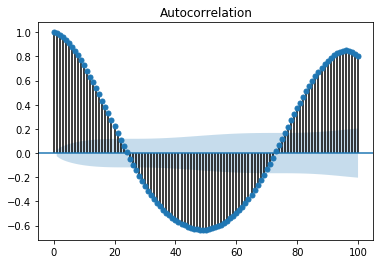

In [7]:
plot_acf(X, lags=100);

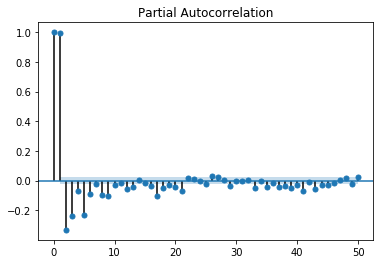

In [8]:
# t-1
plot_pacf(X, lags=50);

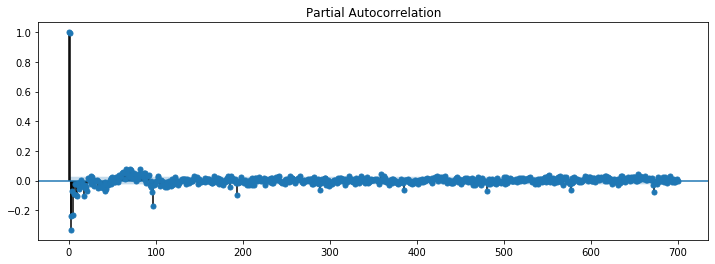

In [9]:
# daily repetition (96 * n cycle)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plot_pacf(X, lags=700, ax=ax);

# 2. Modelling: ARIMA

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5847
Model:                     ARMA(1, 0)   Log Likelihood               23587.036
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sun, 16 Jun 2019   AIC                         -47168.072
Time:                        13:09:11   BIC                         -47148.051
Sample:                             0   HQIC                        -47161.110
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0934      0.007     13.431      0.000       0.080       0.107
ar.L1.y        0.9921      0.002    606.290      0.000       0.989       0.995
                                    Roots           

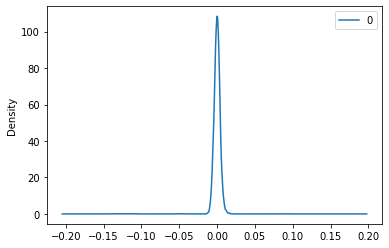

In [10]:
model = ARIMA(X, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
print(residuals.describe())
residuals.plot(kind='kde')
plt.show()

Test MSE: 0.00001


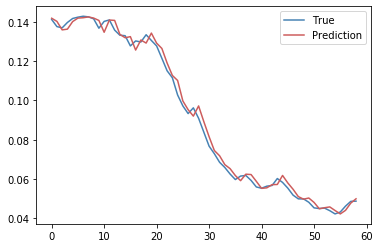

In [11]:
# code source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
from pandas import datetime
from sklearn.metrics import mean_squared_error

size = int(len(X) * 0.99)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(2,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)

# plot
plt.plot(test, color='steelblue', label='True')
plt.plot(predictions, color='indianred', label='Prediction')
plt.legend()
plt.show()

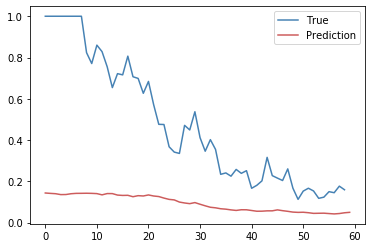

In [12]:
# specific TAZ (model for global mean is meaningless for individual TAZ)
taz_demand = data['geohash6'].value_counts()
sample = taz_demand.index[0]
sample = data[data['geohash6'] == sample].sort_values(['timestep'])
X_ = sample['demand'].values
size = int(len(X_) * 0.99)
train, test = X_[0:size], X_[size:len(X_)]
y_pred = model_fit.predict(len(train), len(train) + len(test))

plt.plot(test, color='steelblue', label='True')
plt.plot(y_pred, color='indianred', label='Prediction')
plt.legend()
plt.show()